In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [23]:
seq_exp = np.load("seq_exp.npy")
zt_freqs = cp.linspace(-90e3, 30e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6
print(zt_rabi * zt_pulse)

0.505


In [24]:
seq_partial = seq_exp[:-80]

In [25]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1000, temp)
cr.raman_cool_with_pumping(
    molecules_dev=mol_0,
    pulses_dev=seq_partial,
    res=res,
)

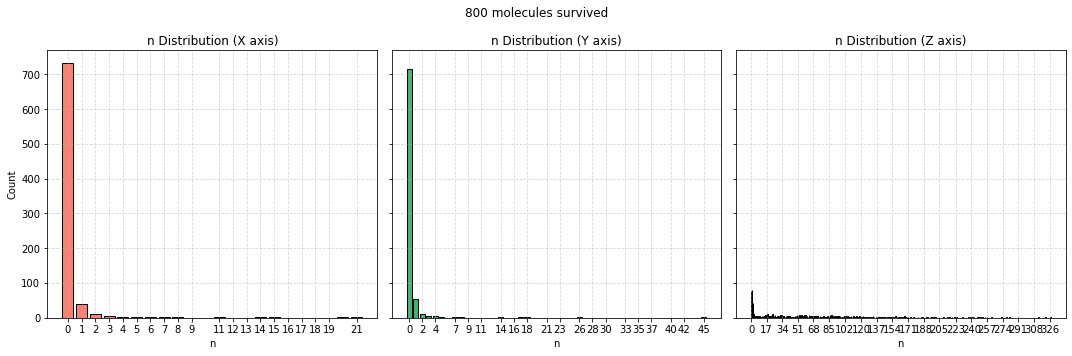

In [26]:
dist = cr.get_n_distribution_gpu(mol_0, max_bins=20)

In [27]:
frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 60.73it/s]


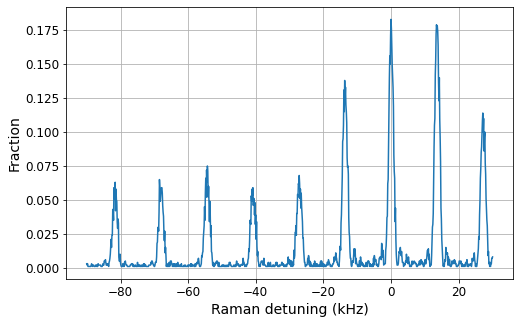

In [28]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

11it [04:46, 26.03s/it]


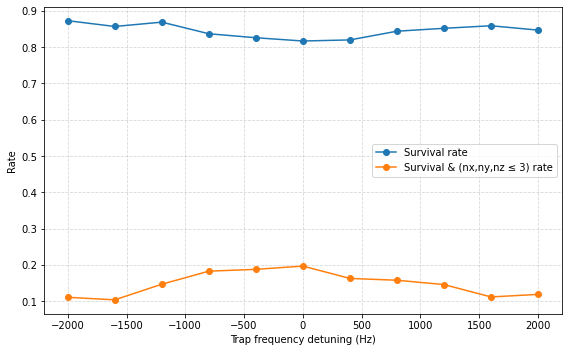

In [18]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

temp = [25e-6, 25e-6, 25e-6]
trap_dets = np.linspace(-2e3, 2e3, 11)

N_mol = 1000  # you used 1000
survival_rate = np.empty(len(trap_dets), dtype=float)
le3_rate = np.empty(len(trap_dets), dtype=float)

for i, det in tqdm(enumerate(trap_dets)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        trap_detuning=(0, 0, float(det)),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate[i] = float((cp.count_nonzero(le3) / N_mol).get())

plt.figure(figsize=(8, 5))
plt.plot(trap_dets, survival_rate, marker="o", label="Survival rate")
plt.plot(trap_dets, le3_rate, marker="o", label="Survival & (nx,ny,nz ≤ 3) rate")
plt.xlabel("Trap frequency detuning (Hz)")
plt.ylabel("Rate")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


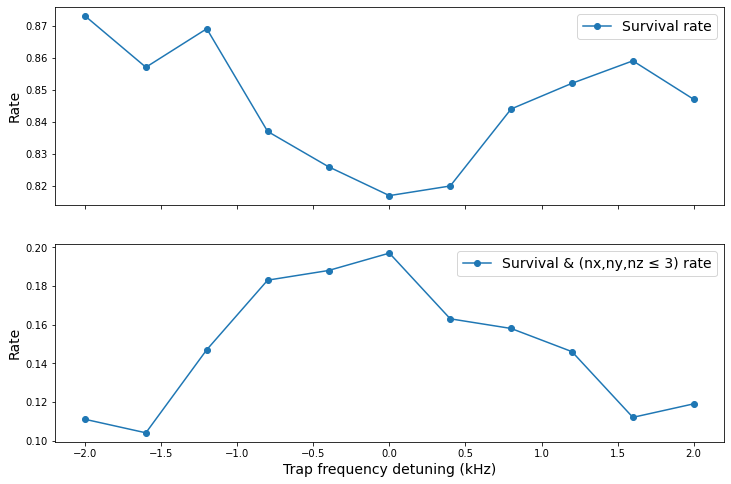

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(trap_dets*1e-3, survival_rate, marker="o", label="Survival rate")
ax[1].plot(trap_dets*1e-3, le3_rate, marker="o", label="Survival & (nx,ny,nz ≤ 3) rate")
ax[1].set_xlabel("Trap frequency detuning (kHz)", fontsize=14)
ax[0].set_ylabel("Rate", fontsize=14)
ax[1].set_ylabel("Rate", fontsize=14)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)